##  Criação de Modelos Preditivos Quanto ao Interesse nos Produtos


O objetivo principal desse Case foi, a partir de um banco de dados reais referente à anuncios de utilitários domésticos, desenvolver modelos que conseguissem classificar um determinado produto entre "interessante = 1 " e "não interessante = 0", a partir de suas características. Além disso, indicar por meio de análise descritiva, quais produtos, e com quais características, apresentam maior interesse do cliente.

Pois bem, para isso, fiz uso de sete diferentes classificadores (SVM, Arvore de Decisão, Floresta Aleatória, KNN, LDA, Nave Bayes e Regressão Logística) selecionados a partir do seu desempenho sob a métrica F1-Score (dado  ao desbalanceamento entre "interesse" e "não interesse" no produto. 

Observei também que agregar todos os produtos em um único modelo seria pouco interpretativo, e perderia assim, a capacidade preditiva. Desta forma, dividi o banco em estratos (a partir do produto) e apliquei, após tratamento dos dados, a técnica Holdout para validação dos modelos. 

obs: Seria interessante replicar o script, porém fazendo uso de validação cruzada repetida. Que não foi usada nesse Case dado o custo computacional demandado. 

Por fim, pelo método das Árvores Extra, hierarquizei as variáveis explicativas mediante sua importância para previsão do interesse, em cada um dos produtos, a fim de retornar as principais características dentro de cada um do modelos (ao que se refere a influência na classificação do modelo). 

OBS: Ao longo desse scrip, existem algumas outras explicações secundárias, ao resumo descrito acima.

In [256]:
## Importando as bibliotecas necessárias 
import pandas as pd
import seaborn as sns 
import numpy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
import numpy as np
import math
import pandas
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

### 1. Tratamento do Dataset Fornecido

In [2]:
## Mudando Diretório
import os 
os.chdir('C:\\Users\\LAION E JANA\\Downloads')  


In [3]:
#### Definindo os  dados
dados = pd.read_csv("problem1_dataset.csv")
###### Dimensão 
dados.shape

(180275, 21)

In [4]:
###### Classe das variáveis
dados.dtypes

ITEM_ID                int64
ALTURA               float64
CAPACIDADE_(L)       float64
COMPOSICAO            object
COR                   object
FORMATO               object
LARGURA              float64
MARCA                 object
PARA_LAVA_LOUCAS      object
PARA_MICRO_ONDAS      object
PESO                 float64
PROFUNDIDADE         float64
TEMPO_GARANTIA       float64
TEM_FERRO_FUNDIDO     object
TEM_GRELHA            object
TEM_TAMPA            float64
TIPO_PRODUTO          object
TIPO_WOK              object
SESSION_ID           float64
ITEM_PRICE           float64
INTERESTED           float64
dtype: object

In [5]:
###### Tratando Variáveis com Base nas Classes
dados['INTERESTED'] = dados['INTERESTED'].astype('category') # Categorizando a variável resposta
dados['TEM_TAMPA'] = dados['TEM_TAMPA'].astype('category') # Categorizando a variável pela presença de tampa na panela
def tran_cat_to_num(dados):
    if dados['TEM_GRELHA'] == 'SIM':
        return 1
    elif dados['TEM_GRELHA'] == 'NAO':
        return 0
dados['TEM_GRELHA'] = dados.apply(tran_cat_to_num,axis=1)
dados['TEM_GRELHA'] = dados['TEM_GRELHA'].astype('category') # Categorizando a variável pela presença de grelha na panela
def tran_cat_to_num_2(dados):
    if dados['TEM_FERRO_FUNDIDO'] == 'SIM':
        return 1
    elif dados['TEM_FERRO_FUNDIDO'] == 'NAO':
        return 0
dados['TEM_FERRO_FUNDIDO'] = dados.apply(tran_cat_to_num_2,axis=1)
dados['TEM_FERRO_FUNDIDO'] = dados['TEM_FERRO_FUNDIDO'].astype('category') # Categorizando a variável pelo material # ferro fundido ou n #
def tran_cat_to_num_3(dados):
    if dados['TIPO_WOK'] == 'SIM':
        return 1
    elif dados['TIPO_WOK'] == 'NAO':
        return 0
dados['TIPO_WOK'] = dados.apply(tran_cat_to_num_3,axis=1)
dados['TIPO_WOK'] = dados['TIPO_WOK'].astype('category') # Categorizando a variável por ser ou nao Wok
def tran_cat_to_num_4(dados):
    if dados['PARA_MICRO_ONDAS'] == 'yes':
        return 1
    elif dados['PARA_MICRO_ONDAS'] == 'no':
        return 0
dados['PARA_MICRO_ONDAS'] = dados.apply(tran_cat_to_num_4,axis=1)
dados['PARA_MICRO_ONDAS']= dados['PARA_MICRO_ONDAS'].astype('category') # Categorizando a variável pela possibilidade de ir ou não ao microondas 
def tran_cat_to_num_5(dados):
    if (dados['PARA_LAVA_LOUCAS'] == 'No')  or (dados['PARA_LAVA_LOUCAS'] == 'NAO') :
        return 0
    else:
        return 1
dados['PARA_LAVA_LOUCAS'] = dados.apply(tran_cat_to_num_5,axis=1)
dados['PARA_LAVA_LOUCAS']  = dados['PARA_LAVA_LOUCAS'].astype('category')  # Categorizando a variável pela possibilidade de ir ou não ao lava-louças 
def tran_cat_to_num_6(dados):
    if (dados['COMPOSICAO'] == 'ALUMINIO')  :
        return 0
    elif dados['COMPOSICAO'] == 'INOX':
        return 1
    elif dados['COMPOSICAO'] == 'CERAMICA':
        return 2
    else:
        return 3
dados['COMPOSICAO'] = dados.apply(tran_cat_to_num_6,axis=1)
dados['COMPOSICAO']  = dados['COMPOSICAO'].astype('category')  
 # Categorizando demais variáveis para que seja possível conversão nas bibliotecas de ML
def tran_cat_to_num_7(dados):
    if (dados['FORMATO'] == 'REDONDO')  :
        return 0
    elif dados['FORMATO'] == 'QUADRADO':
        return 1
    elif dados['FORMATO'] == 'FRIGIDEIRA':
        return 2
    elif dados['FORMATO'] ==  'RETANGULAR':
        return 3
    else:
        return 4
dados['FORMATO'] = dados.apply(tran_cat_to_num_7,axis=1)
dados['FORMATO']  = dados['FORMATO'].astype('category')  
def tran_cat_to_num_8(dados):
    if (dados['COR'] == 'INOX')  :
        return 0
    elif dados['COR'] == 'PRETO':
        return 1
    elif dados['COR'] == 'VERMELHO':
        return 2
    elif dados['COR'] ==  'CEREJA':
        return 3
    elif dados['COR'] ==  'COLORIDO':
        return 4
    elif dados['COR'] ==  'GRAFITE':
        return 5
    elif dados['COR'] ==  'VINHO':
        return 6
    else:
        return 7
dados['COR'] = dados.apply(tran_cat_to_num_8,axis=1)
dados['COR']  = dados['COR'].astype('category') 
def tran_cat_to_num_9(dados):
    if (dados['MARCA'] == 'TRAMONTINA')  :
        return 0
    elif dados['MARCA'] == 'LA CUISINE':
        return 1
    elif dados['MARCA'] == 'PANELA MINEIRA':
        return 2
    elif dados['MARCA'] ==  'BRINOX':
        return 3
    elif dados['MARCA'] ==  'VEC':
        return 4
    elif dados['MARCA'] ==  'EURO HOME':
        return 5
    elif dados['MARCA'] ==  'FUMIL':
        return 6
    elif dados['MARCA'] ==  'HERCULES':
        return 7
    elif dados['MARCA'] ==  'EURO':
        return 8
    elif dados['MARCA'] ==  'HAPPYCALL':
        return 9
    else:
        return 10
dados['MARCA'] = dados.apply(tran_cat_to_num_9,axis=1)
dados['MARCA']  = dados['MARCA'].astype('category')  

del dados['ITEM_ID'] # Apagando Variável sem explicabilidade para os modelos
del dados['SESSION_ID'] # Apagando Variável sem explicabilidade para os modelos

   

   






In [6]:
###### Classe das variáveis após Tratamento
dados.dtypes

ALTURA                float64
CAPACIDADE_(L)        float64
COMPOSICAO           category
COR                  category
FORMATO              category
LARGURA               float64
MARCA                category
PARA_LAVA_LOUCAS     category
PARA_MICRO_ONDAS     category
PESO                  float64
PROFUNDIDADE          float64
TEMPO_GARANTIA        float64
TEM_FERRO_FUNDIDO    category
TEM_GRELHA           category
TEM_TAMPA            category
TIPO_PRODUTO           object
TIPO_WOK             category
ITEM_PRICE            float64
INTERESTED           category
dtype: object

In [7]:
dados['INTERESTED'].value_counts()  # Variável resposta desbalanceada 

0.0    164748
1.0     15527
Name: INTERESTED, dtype: int64

#### 1.1 Análise sobre os produtos de maior interesse

Pelo Gráfico abaixo, é possível destacar que os itens: Panela, Pipoqueira, Chaleira, Caçarola e Frigideira, apresentam em ordem decrescente, a maior parcela de interesse do consumidor. Vale destacar a diferença relativa entre o produto Panela e os demais.  

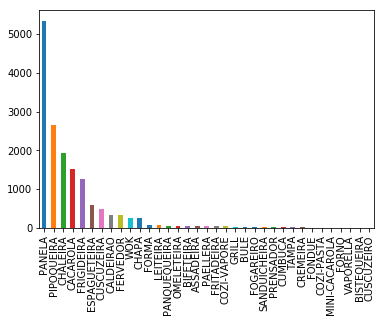

In [8]:
interesse = dados['INTERESTED']==1
dados_filtrados = dados[interesse]
dados_filtrados['TIPO_PRODUTO'].value_counts().plot('bar')

#### 1.2 Criação dos Bancos de Dados a partir do Tipo do Produto

Posto isso, a ideia a seguir é criar bancos de dados estratificados a partir do tipo do produto. Para possibilitar a criação de modelos individuais para cada caso.

In [9]:
dados_panela = dados.loc[dados['TIPO_PRODUTO']=='PANELA']
dados_pipoqueira = dados.loc[dados['TIPO_PRODUTO']=='PIPOQUEIRA']
dados_chaleira = dados.loc[dados['TIPO_PRODUTO']=='CHALEIRA']
dados_cacarola = dados.loc[dados['TIPO_PRODUTO']=='CACAROLA']
dados_frigideira = dados.loc[dados['TIPO_PRODUTO']=='FRIGIDEIRA']
dados_espagueteira = dados.loc[dados['TIPO_PRODUTO']=='ESPAGUETEIRA']
dados_cuscuzeira = dados.loc[(dados['TIPO_PRODUTO']=='CUSCUZEIRA') | (dados['TIPO_PRODUTO']=='CUSCUZEIRO')]
dados_chapa = dados.loc[dados['TIPO_PRODUTO']=='CHAPA']
dados_wok = dados.loc[dados['TIPO_PRODUTO']=='WOK']
dados_caldeirao = dados.loc[dados['TIPO_PRODUTO']=='CALDEIRAO']
dados_fervedor = dados.loc[(dados['TIPO_PRODUTO']=='FERVEDOR') | (dados['TIPO_PRODUTO']=='CANECA/FERVEDOR')]  
dados_grill = dados.loc[dados['TIPO_PRODUTO']=='GRILL']
dados_paellera = dados.loc[dados['TIPO_PRODUTO']=='PAELLERA']
dados_bifeteira = dados.loc[dados['TIPO_PRODUTO']=='BIFETEIRA']
dados_bule = dados.loc[dados['TIPO_PRODUTO']=='BULE']
dados_panquequeira = dados.loc[dados['TIPO_PRODUTO']=='PANQUEQUEIRA']
dados_leiteira = dados.loc[dados['TIPO_PRODUTO']=='LEITEIRA']
dados_forma = dados.loc[dados['TIPO_PRODUTO']=='FORMA']
dados_fritadeira = dados.loc[dados['TIPO_PRODUTO']=='FRITADEIRA']
dados_omeleteira = dados.loc[dados['TIPO_PRODUTO']=='OMELETEIRA']
dados_cozi_vapore = dados.loc[dados['TIPO_PRODUTO']=='COZI-VAPORE']
dados_fogareiro = dados.loc[dados['TIPO_PRODUTO']=='FOGAREIRO']
dados_assadeira = dados.loc[dados['TIPO_PRODUTO']=='ASSADEIRA']
dados_mini_cacarola = dados.loc[dados['TIPO_PRODUTO']=='MINI-CACAROLA']
dados_cremeria = dados.loc[dados['TIPO_PRODUTO']=='CREMEIRA']
dados_sanduicheira = dados.loc[dados['TIPO_PRODUTO']=='SANDUICHEIRA']
dados_tampa = dados.loc[dados['TIPO_PRODUTO']=='TAMPA']
dados_founde = dados.loc[dados['TIPO_PRODUTO']=='FONDUE']
dados_cumbuca = dados.loc[dados['TIPO_PRODUTO']=='CUMBUCA']
dados_prensador = dados.loc[dados['TIPO_PRODUTO']=='PRENSADOR'] # 
dados_forno = dados.loc[dados['TIPO_PRODUTO']=='FORNO'] # Interesse Raro 
dados_cozi_pasta = dados.loc[dados['TIPO_PRODUTO']=='COZI-PASTA'] # Interesse definido pelo preço do item 
dados_papeiro = dados.loc[dados['TIPO_PRODUTO']=='PAPEIRO'] # Daqui pra baixo n tem interesse 
dados_vaporella = dados.loc[dados['TIPO_PRODUTO']=='VAPORELLA']
dados_bistequeria = dados.loc[dados['TIPO_PRODUTO']=='BISTEQUEIRA']
dados_caneco = dados.loc[dados['TIPO_PRODUTO']=='CANECO']

*Percebe-se que alguns produtos estão replicados, bem como 4 dos produtos não apresentaram nenhum interesse por parte do cliente*. Sendo portanto, retirados da análise, e considerados, deterministicamente, como não interessantes.

In [10]:
### Verificando NAN's 

##### Função para dados missing
def funcao_dados_missing(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Frequencia de NANs', 1 : '% Equivalente'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% Equivalente', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns


In [11]:
dim = dados_panela.shape
funcao_dados_missing(dados_panela) #Identificando NAN's Dados Panela

Your selected dataframe has 19 columns.
There are 8 columns that have missing values.


,Frequencia de NANs,% Equivalente
PESO,29701,47.6
PARA_MICRO_ONDAS,29238,46.8
CAPACIDADE_(L),28892,46.3
TEMPO_GARANTIA,4958,7.9
ITEM_PRICE,2610,4.2
ALTURA,466,0.7
LARGURA,466,0.7
PROFUNDIDADE,466,0.7


In [12]:
dados_panela['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    31897
1.0    30521
Name: TEM_TAMPA, dtype: int64

In [13]:
x= ['PESO','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_panela = dados_panela.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_panela.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_panela.shape
print(dim,newdim, sep=",")

(62418, 19),(55774, 12)


In [14]:
dim = dados_pipoqueira.shape
funcao_dados_missing(dados_pipoqueira) #Identificando NAN's Dados Pipoqueira

Your selected dataframe has 19 columns.
There are 8 columns that have missing values.


,Frequencia de NANs,% Equivalente
PARA_MICRO_ONDAS,20404,72.2
TEMPO_GARANTIA,17684,62.6
CAPACIDADE_(L),10563,37.4
PESO,2720,9.6
ALTURA,450,1.6
LARGURA,450,1.6
PROFUNDIDADE,450,1.6
ITEM_PRICE,139,0.5


In [15]:
dados_pipoqueira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

1.0    25527
0.0     2720
Name: TEM_TAMPA, dtype: int64

In [16]:
x= ['TEMPO_GARANTIA','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO','TIPO_WOK','TIPO_PRODUTO']
dados_pipoqueira = dados_pipoqueira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_pipoqueira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_pipoqueira.shape
print(dim,newdim, sep=",")

(28247, 19),(25522, 13)


In [17]:
dim = dados_chaleira.shape
funcao_dados_missing(dados_chaleira) #Identificando NAN's Dados Chaleira

Your selected dataframe has 19 columns.
There are 8 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),11257,64.7
PESO,11006,63.3
PARA_MICRO_ONDAS,10659,61.3
TEMPO_GARANTIA,2299,13.2
ITEM_PRICE,523,3.0
ALTURA,347,2.0
LARGURA,347,2.0
PROFUNDIDADE,347,2.0


In [18]:
dados_chaleira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    16711
1.0      675
Name: TEM_TAMPA, dtype: int64

In [19]:
x= ['PESO','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO','TIPO_WOK','TIPO_PRODUTO']
dados_chaleira = dados_chaleira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_chaleira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_chaleira.shape
print(dim,newdim, sep=",")

(17386, 19),(14694, 13)


In [20]:
dim = dados_cacarola.shape
funcao_dados_missing(dados_cacarola) #Identificando NAN's Dados Caçarola

Your selected dataframe has 19 columns.
There are 8 columns that have missing values.


,Frequencia de NANs,% Equivalente
PESO,10455,62.7
CAPACIDADE_(L),9940,59.6
PARA_MICRO_ONDAS,7918,47.5
TEMPO_GARANTIA,7713,46.3
ALTURA,4632,27.8
LARGURA,4632,27.8
PROFUNDIDADE,4632,27.8
ITEM_PRICE,2715,16.3


In [21]:
x= ['PESO','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO', 'TEMPO_GARANTIA','COMPOSICAO','ALTURA','LARGURA','PROFUNDIDADE','TIPO_WOK','TIPO_PRODUTO']
dados_cacarola = dados_cacarola.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_cacarola.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_cacarola.shape
print(dim,newdim, sep=",")

(16672, 19),(13957, 8)


In [22]:
dim = dados_frigideira.shape
funcao_dados_missing(dados_frigideira) #Identificando NAN's Dados Frigideira

Your selected dataframe has 19 columns.
There are 8 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),13370,81.9
PESO,9685,59.3
PARA_MICRO_ONDAS,8659,53.0
TEMPO_GARANTIA,5893,36.1
ITEM_PRICE,2588,15.9
ALTURA,1633,10.0
LARGURA,1633,10.0
PROFUNDIDADE,1633,10.0


In [23]:
dados_frigideira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    14137
1.0     2188
Name: TEM_TAMPA, dtype: int64

In [24]:
x= ['PESO','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO', 'TEMPO_GARANTIA','COR','TIPO_WOK','TIPO_PRODUTO']
dados_frigideira = dados_frigideira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_frigideira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_frigideira.shape
print(dim,newdim, sep=",")

(16325, 19),(12420, 11)


In [25]:
dim = dados_espagueteira.shape
funcao_dados_missing(dados_espagueteira) #Identificando NAN's Dados Espagueteira

Your selected dataframe has 19 columns.
There are 8 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),5235,64.9
PARA_MICRO_ONDAS,1474,18.3
PESO,1474,18.3
TEMPO_GARANTIA,688,8.5
ITEM_PRICE,367,4.6
ALTURA,63,0.8
LARGURA,63,0.8
PROFUNDIDADE,63,0.8


In [26]:
dados_espagueteira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

1.0    7031
0.0    1031
Name: TEM_TAMPA, dtype: int64

In [175]:
x= ['PESO','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO','TIPO_WOK','TIPO_PRODUTO']
dados_espagueteira = dados_espagueteira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_espagueteira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_espagueteira.shape
print(dim,newdim, sep=",")

(88, 19),(7184, 13)


In [28]:
dim = dados_cuscuzeira.shape
funcao_dados_missing(dados_cuscuzeira) #Identificando NAN's Dados Cuscuzeira

Your selected dataframe has 19 columns.
There are 8 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),6882,99.7
PESO,2277,33.0
PARA_MICRO_ONDAS,1758,25.5
TEMPO_GARANTIA,1758,25.5
ALTURA,519,7.5
LARGURA,519,7.5
PROFUNDIDADE,519,7.5
ITEM_PRICE,105,1.5


In [29]:
dados_cuscuzeira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    6871
1.0      30
Name: TEM_TAMPA, dtype: int64

In [30]:
x= ['PESO','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO','TEMPO_GARANTIA','TIPO_WOK','TIPO_PRODUTO']
dados_cuscuzeira = dados_cuscuzeira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_cuscuzeira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_cuscuzeira.shape
print(dim,newdim, sep=",")

(6901, 19),(6304, 12)


In [31]:
dim = dados_chapa.shape
funcao_dados_missing(dados_chapa) #Identificando NAN's Dados Chapa

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),5028,100.0
PARA_MICRO_ONDAS,5028,100.0
PESO,5028,100.0
TEMPO_GARANTIA,4821,95.9
ITEM_PRICE,659,13.1


In [32]:
dados_chapa['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    5028
1.0       0
Name: TEM_TAMPA, dtype: int64

In [33]:
x= ['PESO','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO','TEMPO_GARANTIA','COMPOSICAO','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_chapa = dados_chapa.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_chapa.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_chapa.shape
print(dim,newdim, sep=",")

(5028, 19),(4369, 10)


In [34]:
dim = dados_wok.shape
funcao_dados_missing(dados_wok) #Identificando NAN's Dados Wok

Your selected dataframe has 19 columns.
There are 8 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),4166,86.3
TEMPO_GARANTIA,2330,48.3
PARA_MICRO_ONDAS,1765,36.6
PESO,1765,36.6
ITEM_PRICE,1014,21.0
ALTURA,402,8.3
LARGURA,402,8.3
PROFUNDIDADE,402,8.3


In [35]:
dados_wok['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

1.0    4097
0.0     732
Name: TEM_TAMPA, dtype: int64

In [36]:
x= ['PESO','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO','TEMPO_GARANTIA','TIPO_WOK','TIPO_PRODUTO']
dados_wok = dados_wok.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_wok.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_wok.shape
print(dim,newdim, sep=",")

(4829, 19),(3477, 12)


In [37]:
dim = dados_caldeirao.shape
funcao_dados_missing(dados_caldeirao) #Identificando NAN's Dados Caldeirão

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
TEMPO_GARANTIA,374,14.7
PARA_MICRO_ONDAS,337,13.3
PESO,337,13.3
CAPACIDADE_(L),299,11.8
ITEM_PRICE,196,7.7


In [38]:
dados_caldeirao['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

1.0    2131
0.0     406
Name: TEM_TAMPA, dtype: int64

In [39]:
x= ['PESO','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO','TEMPO_GARANTIA','TIPO_WOK','TIPO_PRODUTO']
dados_caldeirao = dados_caldeirao.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_caldeirao.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_caldeirao.shape
print(dim,newdim, sep=",")

(2537, 19),(2341, 12)


In [40]:
dim = dados_fervedor.shape
funcao_dados_missing(dados_fervedor) #Identificando NAN's Dados Fervedor

Your selected dataframe has 19 columns.
There are 8 columns that have missing values.


,Frequencia de NANs,% Equivalente
TEMPO_GARANTIA,2400,100.0
CAPACIDADE_(L),2236,93.2
PARA_MICRO_ONDAS,380,15.8
PESO,380,15.8
ITEM_PRICE,130,5.4
ALTURA,107,4.5
LARGURA,107,4.5
PROFUNDIDADE,107,4.5


In [41]:
dados_fervedor['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    2400
1.0       0
Name: TEM_TAMPA, dtype: int64

In [42]:
x= ['PESO','PARA_MICRO_ONDAS','CAPACIDADE_(L)','FORMATO','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','COR','TIPO_PRODUTO']
dados_fervedor = dados_fervedor.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_fervedor.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_fervedor.shape
print(dim,newdim, sep=",")

(2400, 19),(2188, 10)


In [43]:
dim = dados_grill.shape
funcao_dados_missing(dados_grill) #Identificando NAN's Dados Grill

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
PARA_MICRO_ONDAS,1156,100.0
PESO,1124,97.2
TEMPO_GARANTIA,1083,93.7
ITEM_PRICE,204,17.6
CAPACIDADE_(L),163,14.1


In [44]:
dados_grill['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    1156
1.0       0
Name: TEM_TAMPA, dtype: int64

In [45]:
x= ['PESO','PARA_MICRO_ONDAS','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_grill = dados_grill.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_grill.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_grill.shape
print(dim,newdim, sep=",")

(1156, 19),(884, 13)


In [46]:
dim = dados_paellera.shape
funcao_dados_missing(dados_paellera) #Identificando NAN's Dados Paellera

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
TEMPO_GARANTIA,619,75.4
CAPACIDADE_(L),517,63.0
ITEM_PRICE,262,31.9
PESO,210,25.6
PARA_MICRO_ONDAS,58,7.1


In [47]:
dados_paellera['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    517
1.0    304
Name: TEM_TAMPA, dtype: int64

In [48]:
x= ['COR','FORMATO','TEMPO_GARANTIA','CAPACIDADE_(L)','TIPO_WOK','TIPO_PRODUTO']
dados_paellera = dados_paellera.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_paellera.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_paellera.shape
print(dim,newdim, sep=",")

(821, 19),(432, 13)


In [49]:
dim = dados_bifeteira.shape
funcao_dados_missing(dados_bifeteira) #Identificando NAN's Dados Bifeteira

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),745,100.0
PARA_MICRO_ONDAS,745,100.0
PESO,745,100.0
TEMPO_GARANTIA,745,100.0
ITEM_PRICE,88,11.8


In [50]:
dados_bifeteira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    745
1.0      0
Name: TEM_TAMPA, dtype: int64

In [51]:
x= ['PESO','COMPOSICAO','PARA_MICRO_ONDAS','TEMPO_GARANTIA','CAPACIDADE_(L)','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_bifeteira = dados_bifeteira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_bifeteira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_bifeteira.shape
print(dim,newdim, sep=",")

(745, 19),(657, 11)


In [52]:
dim = dados_bule.shape
funcao_dados_missing(dados_bule) #Identificando NAN's Dados Bule

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
ITEM_PRICE,154,20.7
ALTURA,104,14.0
LARGURA,104,14.0
PESO,104,14.0
PROFUNDIDADE,104,14.0


In [53]:
dados_bule['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    744
1.0      0
Name: TEM_TAMPA, dtype: int64

In [54]:
x= ['FORMATO','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_bule = dados_bule.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_bule.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_bule.shape
print(dim,newdim, sep=",")

(744, 19),(525, 15)


In [55]:
dim = dados_panquequeira.shape
funcao_dados_missing(dados_panquequeira) #Identificando NAN's Dados Panquequeira

Your selected dataframe has 19 columns.
There are 8 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),703,100.0
PARA_MICRO_ONDAS,388,55.2
PESO,388,55.2
TEMPO_GARANTIA,388,55.2
ITEM_PRICE,97,13.8
ALTURA,64,9.1
LARGURA,64,9.1
PROFUNDIDADE,64,9.1


In [56]:
dados_panquequeira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    703
1.0      0
Name: TEM_TAMPA, dtype: int64

In [57]:
x= ['FORMATO','CAPACIDADE_(L)','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','COR','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_panquequeira = dados_panquequeira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_panquequeira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_panquequeira.shape
print(dim,newdim, sep=",")

(703, 19),(568, 10)


In [58]:
dim = dados_leiteira.shape
funcao_dados_missing(dados_leiteira) #Identificando NAN's Dados Leiteira

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),223,32.1
PARA_MICRO_ONDAS,222,31.9
PESO,222,31.9
TEMPO_GARANTIA,222,31.9
ITEM_PRICE,63,9.1


In [59]:
dados_leiteira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    694
1.0      1
Name: TEM_TAMPA, dtype: int64

In [60]:
x= ['FORMATO','CAPACIDADE_(L)','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_leiteira = dados_leiteira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_leiteira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_leiteira.shape
print(dim,newdim, sep=",")

(695, 19),(632, 11)


In [61]:
dim = dados_forma.shape
funcao_dados_missing(dados_forma) #Identificando NAN's Dados Forma

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),608,100.0
PARA_MICRO_ONDAS,605,99.5
PESO,605,99.5
TEMPO_GARANTIA,605,99.5
ITEM_PRICE,86,14.1


In [62]:
dados_forma['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    574
1.0     34
Name: TEM_TAMPA, dtype: int64

In [63]:
x= ['COMPOSICAO','FORMATO','CAPACIDADE_(L)','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TIPO_WOK','TIPO_PRODUTO']
dados_forma = dados_forma.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_forma.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_forma.shape
print(dim,newdim, sep=",")

(608, 19),(522, 11)


In [64]:
dim = dados_fritadeira.shape
funcao_dados_missing(dados_fritadeira) #Identificando NAN's Dados Forma

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),552,100.0
PARA_MICRO_ONDAS,552,100.0
PESO,552,100.0
TEMPO_GARANTIA,552,100.0
ITEM_PRICE,64,11.6


In [65]:
dados_fritadeira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    552
1.0      0
Name: TEM_TAMPA, dtype: int64

In [66]:
x= ['FORMATO','CAPACIDADE_(L)','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_fritadeira = dados_fritadeira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_fritadeira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_fritadeira.shape
print(dim,newdim, sep=",")

(552, 19),(488, 11)


In [67]:
dim = dados_omeleteira.shape
funcao_dados_missing(dados_omeleteira) #Identificando NAN's Dados Omeleteira

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
PARA_MICRO_ONDAS,504,100.0
PESO,504,100.0
TEMPO_GARANTIA,504,100.0
CAPACIDADE_(L),186,36.9
ITEM_PRICE,82,16.3


In [68]:
dados_omeleteira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    504
1.0      0
Name: TEM_TAMPA, dtype: int64

In [69]:
x= ['FORMATO','CAPACIDADE_(L)','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_omeleteira = dados_omeleteira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_omeleteira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_omeleteira.shape
print(dim,newdim, sep=",")

(504, 19),(422, 11)


In [70]:
dim = dados_cozi_vapore.shape
funcao_dados_missing(dados_cozi_vapore) #Identificando NAN's Dados Cozi Vapor

Your selected dataframe has 19 columns.
There are 6 columns that have missing values.


,Frequencia de NANs,% Equivalente
ITEM_PRICE,113,22.8
ALTURA,76,15.3
LARGURA,76,15.3
PESO,76,15.3
PROFUNDIDADE,76,15.3
TEMPO_GARANTIA,76,15.3


In [71]:
dados_cozi_vapore['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    496
1.0      0
Name: TEM_TAMPA, dtype: int64

In [72]:
x= ['FORMATO','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_cozi_vapore = dados_cozi_vapore.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_cozi_vapore.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_cozi_vapore.shape
print(dim,newdim, sep=",")

(496, 19),(379, 15)


In [73]:
dim = dados_fogareiro.shape
funcao_dados_missing(dados_fogareiro) #Identificando NAN's Dados Fogareiro

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),421,100.0
PARA_MICRO_ONDAS,421,100.0
PESO,421,100.0
TEMPO_GARANTIA,421,100.0
ITEM_PRICE,186,44.2


In [74]:
dados_fogareiro['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    421
1.0      0
Name: TEM_TAMPA, dtype: int64

In [75]:
x= ['CAPACIDADE_(L)','COMPOSICAO','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_fogareiro = dados_fogareiro.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_fogareiro.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_fogareiro.shape
print(dim,newdim, sep=",")

(421, 19),(235, 11)


In [76]:
dim = dados_assadeira.shape
funcao_dados_missing(dados_assadeira) #Identificando NAN's Dados Assadeira

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),371,100.0
PARA_MICRO_ONDAS,371,100.0
PESO,371,100.0
TEMPO_GARANTIA,371,100.0
ITEM_PRICE,114,30.7


In [77]:
dados_assadeira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    321
1.0     50
Name: TEM_TAMPA, dtype: int64

In [78]:
x= ['CAPACIDADE_(L)','COMPOSICAO','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TIPO_WOK','TIPO_PRODUTO']
dados_assadeira = dados_assadeira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_assadeira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_assadeira.shape
print(dim,newdim, sep=",")

(371, 19),(257, 12)


In [79]:
dim = dados_mini_cacarola.shape
funcao_dados_missing(dados_mini_cacarola) #Identificando NAN's Dados Mini Caçarola

Your selected dataframe has 19 columns.
There are 4 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),354,100.0
PARA_MICRO_ONDAS,354,100.0
PESO,354,100.0
ITEM_PRICE,102,28.8


In [80]:
dados_mini_cacarola['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    354
1.0      0
Name: TEM_TAMPA, dtype: int64

In [81]:
x= ['CAPACIDADE_(L)','COMPOSICAO','PARA_MICRO_ONDAS','PESO','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_mini_cacarola = dados_mini_cacarola.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_mini_cacarola.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_mini_cacarola.shape
print(dim,newdim, sep=",")

(354, 19),(252, 12)


In [82]:
dim = dados_cremeria.shape
funcao_dados_missing(dados_cremeria) #Identificando NAN's Dados Cremeira

Your selected dataframe has 19 columns.
There are 7 columns that have missing values.


,Frequencia de NANs,% Equivalente
ALTURA,303,100.0
LARGURA,303,100.0
PESO,303,100.0
PROFUNDIDADE,303,100.0
TEMPO_GARANTIA,303,100.0
ITEM_PRICE,95,31.4
CAPACIDADE_(L),3,1.0


In [83]:
dados_cremeria['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    303
1.0      0
Name: TEM_TAMPA, dtype: int64

In [84]:
x= ['ALTURA','FORMATO','LARGURA','PESO','PROFUNDIDADE','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_cremeria = dados_cremeria.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_cremeria.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_cremeria.shape
print(dim,newdim, sep=",")

(303, 19),(207, 10)


In [85]:
dim = dados_sanduicheira.shape
funcao_dados_missing(dados_sanduicheira) #Identificando NAN's Dados Sanduicheira

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),242,100.0
PARA_MICRO_ONDAS,242,100.0
PESO,242,100.0
TEMPO_GARANTIA,242,100.0
ITEM_PRICE,75,31.0


In [86]:
dados_sanduicheira['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    242
1.0      0
Name: TEM_TAMPA, dtype: int64

In [87]:
x= ['CAPACIDADE_(L)','COMPOSICAO','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_sanduicheira = dados_sanduicheira.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_sanduicheira.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_sanduicheira.shape
print(dim,newdim, sep=",")

(242, 19),(167, 11)


In [88]:
dim = dados_tampa.shape
funcao_dados_missing(dados_tampa) #Identificando NAN's Dados Tampa

Your selected dataframe has 19 columns.
There are 4 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),185,100.0
PARA_MICRO_ONDAS,185,100.0
PESO,185,100.0
ITEM_PRICE,39,21.1


In [89]:
dados_tampa['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

1.0    185
0.0      0
Name: TEM_TAMPA, dtype: int64

In [90]:
x= ['CAPACIDADE_(L)','PARA_MICRO_ONDAS','PESO','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_tampa = dados_tampa.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_tampa.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_tampa.shape
print(dim,newdim, sep=",")

(185, 19),(146, 13)


In [91]:
dim = dados_founde.shape
funcao_dados_missing(dados_founde) #Identificando NAN's Dados Founde

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),141,100.0
PARA_MICRO_ONDAS,141,100.0
PESO,141,100.0
TEMPO_GARANTIA,141,100.0
ITEM_PRICE,51,36.2


In [92]:
dados_founde['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    141
1.0      0
Name: TEM_TAMPA, dtype: int64

In [93]:
x= ['CAPACIDADE_(L)','COMPOSICAO','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_founde = dados_founde.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_founde.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_founde.shape
print(dim,newdim, sep=",")

(141, 19),(90, 11)


In [94]:
dim = dados_cumbuca.shape
funcao_dados_missing(dados_cumbuca) #Identificando NAN's Dados Cumbuca

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),119,100.0
PARA_MICRO_ONDAS,119,100.0
PESO,119,100.0
TEMPO_GARANTIA,119,100.0
ITEM_PRICE,47,39.5


In [95]:
dados_cumbuca['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

1.0    119
0.0      0
Name: TEM_TAMPA, dtype: int64

In [96]:
x= ['CAPACIDADE_(L)','COMPOSICAO','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_cumbuca = dados_cumbuca.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_cumbuca.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_cumbuca.shape
print(dim,newdim, sep=",")

(119, 19),(72, 11)


In [97]:
dim = dados_prensador.shape
funcao_dados_missing(dados_prensador) #Identificando NAN's Dados Prensador

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),102,100.0
PARA_MICRO_ONDAS,102,100.0
PESO,102,100.0
TEMPO_GARANTIA,102,100.0
ITEM_PRICE,25,24.5


In [98]:
dados_prensador['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    102
1.0      0
Name: TEM_TAMPA, dtype: int64

In [99]:
dados_prensador['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

0.0    102
1.0      0
Name: TEM_TAMPA, dtype: int64

In [100]:
x= ['CAPACIDADE_(L)','COMPOSICAO','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_prensador = dados_prensador.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_prensador.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_prensador.shape
print(dim,newdim, sep=",")

(102, 19),(77, 11)


In [101]:
dim = dados_forno.shape
funcao_dados_missing(dados_forno) #Identificando NAN's Dados Prensador

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Frequencia de NANs,% Equivalente
CAPACIDADE_(L),88,100.0
PARA_MICRO_ONDAS,88,100.0
PESO,88,100.0
TEMPO_GARANTIA,88,100.0
ITEM_PRICE,28,31.8


In [102]:
dados_forno['TEM_TAMPA'].value_counts()  #Identificando Significancia da Tampa

1.0    88
0.0     0
Name: TEM_TAMPA, dtype: int64

In [103]:
x= ['CAPACIDADE_(L)','COMPOSICAO','PARA_MICRO_ONDAS','PESO','TEMPO_GARANTIA','TEM_TAMPA','TIPO_WOK','TIPO_PRODUTO']
dados_forno = dados_forno.drop(columns=x)  #Retirando Vriáveis pelos excessivos NAN's 
dados_forno.dropna(inplace=True) #Retirando Linhas com NAN's 
newdim= dados_forno.shape
print(dim,newdim, sep=",")

(88, 19),(60, 11)


### 2. Criando os Modelos Preditivos

#### 2.0 Função de Desempenho pela F1-Score

In [150]:
    def funcao_desempenho(X,Y):
        warnings.filterwarnings("ignore")
        Resultados= [[] for i in range(9)]
        Resultados[0]= [nome_dados]
        Resultados[1]= ["Modelo", "Desempenho"]
        MODELO =  LogisticRegression()
        Nome_modelo = 'Regressao Logistica'
# Amostra 70-30 (Holdout)

        X_TREINO,X_TESTE,Y_TREINO, Y_TESTE = train_test_split(X, Y, test_size = 0.3)
        MODELO.fit(X_TREINO,Y_TREINO)
        Y_PRED = MODELO.predict(X_TESTE)
        mc = confusion_matrix(Y_TESTE,Y_PRED)
        tp = mc[0,0]
        tn = mc[1,1]
        fn = mc[1,0]
        fp = mc[0,1]
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
# f1-Score: Dado ao desequilíbrio entre categorias de resposta.
        f1 = (2*prec*rec)/(prec+rec)
        f1 = round(f1,4)
        Resultados[2] = [Nome_modelo, f1]
################################################
        MODELO =  LinearDiscriminantAnalysis()
        Nome_modelo = 'LDA'
# Amostra 70-30 (Holdout)
        X_TREINO,X_TESTE,Y_TREINO, Y_TESTE = train_test_split(X, Y, test_size = 0.3)
        MODELO.fit(X_TREINO,Y_TREINO)
        Y_PRED = MODELO.predict(X_TESTE)
        mc = confusion_matrix(Y_TESTE,Y_PRED)
        tp = mc[0,0]
        tn = mc[1,1]
        fn = mc[1,0]
        fp = mc[0,1]
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
# f1-Score: Dado ao desequilíbrio entre categorias de resposta.
        f1 = (2*prec*rec)/(prec+rec)
        f1 = round(f1,4)
        Resultados[3] = [Nome_modelo, f1]
################################################
        MODELO = KNeighborsClassifier()
        Nome_modelo = 'KNN'
# Amostra 70-30 (Holdout)
        X_TREINO,X_TESTE,Y_TREINO, Y_TESTE = train_test_split(X, Y, test_size = 0.3)
        MODELO.fit(X_TREINO,Y_TREINO)
        Y_PRED = MODELO.predict(X_TESTE)
        mc = confusion_matrix(Y_TESTE,Y_PRED)
        tp = mc[0,0]
        tn = mc[1,1]
        fn = mc[1,0]
        fp = mc[0,1]
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
# f1-Score: Dado ao desequilíbrio entre categorias de resposta.
        f1 = (2*prec*rec)/(prec+rec)
        f1 = round(f1,4)
        Resultados[4] = [Nome_modelo, f1]
################################################
        MODELO =  DecisionTreeClassifier()
        Nome_modelo = 'Arvore de Decisão'
# Amostra 70-30 (Holdout)
        X_TREINO,X_TESTE,Y_TREINO, Y_TESTE = train_test_split(X, Y, test_size = 0.3)
        MODELO.fit(X_TREINO,Y_TREINO)
        Y_PRED = MODELO.predict(X_TESTE)
        mc = confusion_matrix(Y_TESTE,Y_PRED)
        tp = mc[0,0]
        tn = mc[1,1]
        fn = mc[1,0]
        fp = mc[0,1]
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
# f1-Score: Dado ao desequilíbrio entre categorias de resposta.
        f1 = (2*prec*rec)/(prec+rec)
        f1 = round(f1,4)
        Resultados[5] = [Nome_modelo, f1]
################################################
        MODELO =  GaussianNB()
        Nome_modelo = 'Naive Bayes'
# Amostra 70-30 (Holdout)
        X_TREINO,X_TESTE,Y_TREINO, Y_TESTE = train_test_split(X, Y, test_size = 0.3)
        MODELO.fit(X_TREINO,Y_TREINO)
        Y_PRED = MODELO.predict(X_TESTE)
        mc = confusion_matrix(Y_TESTE,Y_PRED)
        tp = mc[0,0]
        tn = mc[1,1]
        fn = mc[1,0]
        fp = mc[0,1]
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
# f1-Score: Dado ao desequilíbrio entre categorias de resposta.
        f1 = (2*prec*rec)/(prec+rec)
        f1 = round(f1,4)
        Resultados[6] = [Nome_modelo, f1]
################################################
        MODELO =  SVC(kernel = 'rbf')
        Nome_modelo = 'SVM - Gaussiano '
# Amostra 70-30 (Holdout)
        X_TREINO,X_TESTE,Y_TREINO, Y_TESTE = train_test_split(X, Y, test_size = 0.3)
        MODELO.fit(X_TREINO,Y_TREINO)
        Y_PRED = MODELO.predict(X_TESTE)
        mc = confusion_matrix(Y_TESTE,Y_PRED)
        tp = mc[0,0]
        tn = mc[1,1]
        fn = mc[1,0]
        fp = mc[0,1]
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
# f1-Score: Dado ao desequilíbrio entre categorias de resposta.
        f1 = (2*prec*rec)/(prec+rec)
        f1 = round(f1,4)
        Resultados[7] = [Nome_modelo, f1]
################################################
        MODELO =  RandomForestClassifier()
        Nome_modelo = 'Floresta Aleatoria'
# Amostra 70-30 (Holdout)
        X_TREINO,X_TESTE,Y_TREINO, Y_TESTE = train_test_split(X, Y, test_size = 0.3)
        MODELO.fit(X_TREINO,Y_TREINO)
        Y_PRED = MODELO.predict(X_TESTE)
        mc = confusion_matrix(Y_TESTE,Y_PRED)
        tp = mc[0,0]
        tn = mc[1,1]
        fn = mc[1,0]
        fp = mc[0,1]
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
# f1-Score: Dado ao desequilíbrio entre categorias de resposta.
        f1 = (2*prec*rec)/(prec+rec)
        f1 = round(f1,4)
        Resultados[8] = [Nome_modelo, f1]
        return Resultados

#### 2.1 Modelo - Produto Tipo : "Panela"

In [151]:

###### Funções Auxiliares
nome_dados = ['dados_panela']
X = dados_panela.loc [:, dados_panela.columns != 'INTERESTED'] 
Y = dados_panela.loc [:, dados_panela.columns == 'INTERESTED']
n = dados_panela.shape[0]
desempenho_panela= funcao_desempenho(X,Y)
desempenho_panela

[[['dados_panela']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9542],
 ['LDA', 0.9527],
 ['KNN', 0.9488],
 ['Arvore de Decisão', 0.9585],
 ['Naive Bayes', 0.9518],
 ['SVM - Gaussiano ', 0.9565],
 ['Floresta Aleatoria', 0.9577]]

#### 2.2 Modelo - Produto Tipo : "Pipoqueira"

In [152]:
###### Funções Auxiliares
nome_dados = ['dados_pipoqueira']
X = dados_pipoqueira.loc [:, dados_pipoqueira.columns != 'INTERESTED'] 
Y = dados_pipoqueira.loc [:, dados_pipoqueira.columns == 'INTERESTED']
n = dados_pipoqueira.shape[0]
desempenho_pipoqueira= funcao_desempenho(X,Y)
desempenho_pipoqueira

[[['dados_pipoqueira']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9476],
 ['LDA', 0.9463],
 ['KNN', 0.9842],
 ['Arvore de Decisão', 0.9821],
 ['Naive Bayes', 0.9427],
 ['SVM - Gaussiano ', 0.9496],
 ['Floresta Aleatoria', 0.9842]]

#### 2.3 Modelo - Produto Tipo : "Chaleira"

In [153]:
###### Funções Auxiliares
nome_dados = ['dados_chaleira']
X = dados_chaleira.loc [:, dados_chaleira.columns != 'INTERESTED'] 
Y = dados_chaleira.loc [:, dados_chaleira.columns == 'INTERESTED']
n = dados_chaleira.shape[0]
desempenho_chaleira= funcao_desempenho(X,Y)
desempenho_chaleira

[[['dados_chaleira']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9377],
 ['LDA', 0.9389],
 ['KNN', 0.9341],
 ['Arvore de Decisão', 0.9439],
 ['Naive Bayes', 0.9215],
 ['SVM - Gaussiano ', 0.9395],
 ['Floresta Aleatoria', 0.9387]]

#### 2.4 Modelo - Produto Tipo : "Caçarola"

In [154]:
###### Funções Auxiliares
nome_dados = ['dados_cacarola']
X = dados_cacarola.loc [:, dados_cacarola.columns != 'INTERESTED'] 
Y = dados_cacarola.loc [:, dados_cacarola.columns == 'INTERESTED']
n = dados_cacarola.shape[0]
desempenho_cacarola= funcao_desempenho(X,Y)
desempenho_cacarola

[[['dados_cacarola']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9458],
 ['LDA', 0.9406],
 ['KNN', 0.933],
 ['Arvore de Decisão', 0.9441],
 ['Naive Bayes', 0.9423],
 ['SVM - Gaussiano ', 0.9453],
 ['Floresta Aleatoria', 0.9407]]

#### 2.5 Modelo - Produto Tipo : "Frigideira"

In [177]:
###### Funções Auxiliares
nome_dados = ['dados_frigideira']
X = dados_frigideira.loc [:, dados_frigideira.columns != 'INTERESTED'] 
Y = dados_frigideira.loc [:, dados_frigideira.columns == 'INTERESTED']
n = dados_frigideira.shape[0]
desempenho_frigideira= funcao_desempenho(X,Y)
desempenho_frigideira

[[['dados_frigideira']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9513],
 ['LDA', 0.9541],
 ['KNN', 0.9484],
 ['Arvore de Decisão', 0.9528],
 ['Naive Bayes', 0.9497],
 ['SVM - Gaussiano ', 0.9528],
 ['Floresta Aleatoria', 0.9503]]

#### 2.6 Modelo - Produto Tipo : "Espagueteira"

In [176]:
###### Funções Auxiliares
nome_dados = ['dados_espagueteira']
X = dados_espagueteira.loc [:, dados_espagueteira.columns != 'INTERESTED'] 
Y = dados_espagueteira.loc [:, dados_espagueteira.columns == 'INTERESTED']
n = dados_espagueteira.shape[0]
desempenho_espagueteira= funcao_desempenho(X,Y)
desempenho_espagueteira

[[['dados_espagueteira']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.961],
 ['LDA', 0.9607],
 ['KNN', 0.9644],
 ['Arvore de Decisão', 0.9619],
 ['Naive Bayes', 0.9615],
 ['SVM - Gaussiano ', 0.966],
 ['Floresta Aleatoria', 0.9642]]

#### 2.7 Modelo - Produto Tipo : "Cuscuzeira"


In [178]:
###### Funções Auxiliares
nome_dados = ['dados_cuscuzeira']
X = dados_cuscuzeira.loc [:, dados_cuscuzeira.columns != 'INTERESTED'] 
Y = dados_cuscuzeira.loc [:, dados_cuscuzeira.columns == 'INTERESTED']
n = dados_cuscuzeira.shape[0]
desempenho_cuscuzeira= funcao_desempenho(X,Y)
desempenho_cuscuzeira

[[['dados_cuscuzeira']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9627],
 ['LDA', 0.9639],
 ['KNN', 0.9606],
 ['Arvore de Decisão', 0.9612],
 ['Naive Bayes', 0.9641],
 ['SVM - Gaussiano ', 0.9598],
 ['Floresta Aleatoria', 0.9623]]

#### 2.8 Modelo - Produto Tipo : "Chapa"

In [179]:
###### Funções Auxiliares
nome_dados = ['dados_chapa']
X = dados_chapa.loc [:, dados_chapa.columns != 'INTERESTED'] 
Y = dados_chapa.loc [:, dados_chapa.columns == 'INTERESTED']
n = dados_chapa.shape[0]
desempenho_chapa= funcao_desempenho(X,Y)
desempenho_chapa

[[['dados_chapa']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9677],
 ['LDA', 0.9726],
 ['KNN', 0.9632],
 ['Arvore de Decisão', 0.9665],
 ['Naive Bayes', 0.9673],
 ['SVM - Gaussiano ', 0.975],
 ['Floresta Aleatoria', 0.9706]]

#### 2.9 Modelo - Produto Tipo : "WOK"

In [180]:
###### Funções Auxiliares
nome_dados = ['dados_wok']
X = dados_wok.loc [:, dados_wok.columns != 'INTERESTED'] 
Y = dados_wok.loc [:, dados_wok.columns == 'INTERESTED']
n = dados_wok.shape[0]
desempenho_wok= funcao_desempenho(X,Y)
desempenho_wok

[[['dados_wok']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9674],
 ['LDA', 0.9689],
 ['KNN', 0.951],
 ['Arvore de Decisão', 0.9642],
 ['Naive Bayes', 0.9684],
 ['SVM - Gaussiano ', 0.9663],
 ['Floresta Aleatoria', 0.9658]]

#### 2.10 Modelo - Produto Tipo : "Caldeirão"

In [181]:
###### Funções Auxiliares
nome_dados = ['dados_caldeirao']
X = dados_caldeirao.loc [:, dados_caldeirao.columns != 'INTERESTED'] 
Y = dados_caldeirao.loc [:, dados_caldeirao.columns == 'INTERESTED']
n = dados_caldeirao.shape[0]
desempenho_caldeirao= funcao_desempenho(X,Y)
desempenho_caldeirao

[[['dados_caldeirao']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9218],
 ['LDA', 0.9259],
 ['KNN', 0.8026],
 ['Arvore de Decisão', 0.923],
 ['Naive Bayes', 0.4856],
 ['SVM - Gaussiano ', 0.92],
 ['Floresta Aleatoria', 0.9296]]

#### 2.11 Modelo - Produto Tipo : "Ferverdor"

In [182]:
###### Funções Auxiliares
nome_dados = ['dados_fervedor']
X = dados_fervedor.loc [:, dados_fervedor.columns != 'INTERESTED'] 
Y = dados_fervedor.loc [:, dados_fervedor.columns == 'INTERESTED']
n = dados_fervedor.shape[0]
desempenho_ferverdor= funcao_desempenho(X,Y)
desempenho_ferverdor

[[['dados_fervedor']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9282],
 ['LDA', 0.9291],
 ['KNN', 0.9172],
 ['Arvore de Decisão', 0.9382],
 ['Naive Bayes', 0.0036],
 ['SVM - Gaussiano ', 0.9221],
 ['Floresta Aleatoria', 0.9261]]

#### 2.12 Modelo - Produto Tipo : "Grill"

In [183]:
###### Funções Auxiliares
nome_dados = ['dados_grill']
X = dados_grill.loc [:, dados_grill.columns != 'INTERESTED'] 
Y = dados_grill.loc [:, dados_grill.columns == 'INTERESTED']
n = dados_grill.shape[0]
desempenho_grill= funcao_desempenho(X,Y)
desempenho_grill

[[['dados_grill']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9905],
 ['LDA', 0.9962],
 ['KNN', 0.9924],
 ['Arvore de Decisão', 0.9962],
 ['Naive Bayes', 0.9924],
 ['SVM - Gaussiano ', 0.9943],
 ['Floresta Aleatoria', 0.9886]]

#### 2.13 Modelo - Produto Tipo : "Paellera"

In [184]:
###### Funções Auxiliares
nome_dados = ['dados_paellera']
X = dados_paellera.loc [:, dados_paellera.columns != 'INTERESTED'] 
Y = dados_paellera.loc [:, dados_paellera.columns == 'INTERESTED']
n = dados_paellera.shape[0]
desempenho_paellera= funcao_desempenho(X,Y)
desempenho_paellera

[[['dados_paellera']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9558],
 ['LDA', 0.9683],
 ['KNN', 0.9683],
 ['Arvore de Decisão', 0.9516],
 ['Naive Bayes', 0.5943],
 ['SVM - Gaussiano ', 0.9388],
 ['Floresta Aleatoria', 0.9683]]

#### 2.14 Modelo - Produto Tipo : "Bifeteira"

In [185]:
###### Funções Auxiliares
nome_dados = ['dados_bifeteira']
X = dados_bifeteira.loc [:, dados_bifeteira.columns != 'INTERESTED'] 
Y = dados_bifeteira.loc [:, dados_bifeteira.columns == 'INTERESTED']
n = dados_bifeteira.shape[0]
desempenho_bifeteira= funcao_desempenho(X,Y)
desempenho_bifeteira

[[['dados_bifeteira']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.944],
 ['LDA', 0.9606],
 ['KNN', 0.9794],
 ['Arvore de Decisão', 0.9714],
 ['Naive Bayes', 0.9661],
 ['SVM - Gaussiano ', 0.9606],
 ['Floresta Aleatoria', 0.9767]]

#### 2.15 Modelo - Produto Tipo : "Bule"

In [186]:
###### Funções Auxiliares
nome_dados = ['dados_bule']
X = dados_bule.loc [:, dados_bule.columns != 'INTERESTED'] 
Y = dados_bule.loc [:, dados_bule.columns == 'INTERESTED']
n = dados_bule.shape[0]
desempenho_bule= funcao_desempenho(X,Y)
desempenho_bule

[[['dados_bule']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9806],
 ['LDA', 0.9839],
 ['KNN', 0.974],
 ['Arvore de Decisão', 0.9707],
 ['Naive Bayes', 0.9739],
 ['SVM - Gaussiano ', 0.974],
 ['Floresta Aleatoria', 0.974]]

#### 2.16 Modelo - Produto Tipo : "Panquequeira"

In [187]:
###### Funções Auxiliares
nome_dados = ['dados_panquequeira']
X = dados_panquequeira.loc [:, dados_panquequeira.columns != 'INTERESTED'] 
Y = dados_panquequeira.loc [:, dados_panquequeira.columns == 'INTERESTED']
n = dados_panquequeira.shape[0]
desempenho_panquequeira= funcao_desempenho(X,Y)
desempenho_panquequeira

[[['dados_panquequeira']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9573],
 ['LDA', 0.9605],
 ['KNN', 0.9477],
 ['Arvore de Decisão', 0.9467],
 ['Naive Bayes', 0.9573],
 ['SVM - Gaussiano ', 0.9477],
 ['Floresta Aleatoria', 0.9697]]

#### 2.17 Modelo - Produto Tipo : "Leiteira"

In [188]:
###### Funções Auxiliares
nome_dados = ['dados_leiteira']
X = dados_leiteira.loc [:, dados_leiteira.columns != 'INTERESTED'] 
Y = dados_leiteira.loc [:, dados_leiteira.columns == 'INTERESTED']
n = dados_leiteira.shape[0]
desempenho_leiteira= funcao_desempenho(X,Y)
desempenho_leiteira

[[['dados_leiteira']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9444],
 ['LDA', 0.9503],
 ['KNN', 0.9356],
 ['Arvore de Decisão', 0.9474],
 ['Naive Bayes', 0.2985],
 ['SVM - Gaussiano ', 0.9326],
 ['Floresta Aleatoria', 0.9356]]

#### 2.18 Modelo - Produto Tipo : "Forma"

In [189]:
###### Funções Auxiliares
nome_dados = ['dados_forma']
X = dados_forma.loc [:, dados_forma.columns != 'INTERESTED'] 
Y = dados_forma.loc [:, dados_forma.columns == 'INTERESTED']
n = dados_forma.shape[0]
desempenho_forma= funcao_desempenho(X,Y)
desempenho_forma

[[['dados_forma']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.921],
 ['LDA', 0.9135],
 ['KNN', 0.816],
 ['Arvore de Decisão', 0.9283],
 ['Naive Bayes', 0.1268],
 ['SVM - Gaussiano ', 0.921],
 ['Floresta Aleatoria', 0.9247]]

#### 2.19 Modelo - Produto Tipo : "Fritadeira"

In [190]:
###### Funções Auxiliares
nome_dados = ['dados_paellera']
X = dados_fritadeira.loc [:, dados_fritadeira.columns != 'INTERESTED'] 
Y = dados_fritadeira.loc [:, dados_fritadeira.columns == 'INTERESTED']
n = dados_fritadeira.shape[0]
desempenho_fritadeira= funcao_desempenho(X,Y)
desempenho_fritadeira

[[['dados_paellera']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9792],
 ['LDA', 0.9574],
 ['KNN', 0.95],
 ['Arvore de Decisão', 0.9754],
 ['Naive Bayes', 0.9265],
 ['SVM - Gaussiano ', 0.9684],
 ['Floresta Aleatoria', 0.9648]]

#### 2.20 Modelo - Produto Tipo : "Omeleteira"

In [192]:
###### Funções Auxiliares
nome_dados = ['dados_paellera']
X = dados_omeleteira.loc [:, dados_omeleteira.columns != 'INTERESTED'] 
Y = dados_omeleteira.loc [:, dados_omeleteira.columns == 'INTERESTED']
n = dados_omeleteira.shape[0]
desempenho_omeleteira= funcao_desempenho(X,Y)
desempenho_omeleteira

[[['dados_paellera']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9372],
 ['LDA', 0.8899],
 ['KNN', 0.9417],
 ['Arvore de Decisão', 0.9547],
 ['Naive Bayes', 0.8858],
 ['SVM - Gaussiano ', 0.9547],
 ['Floresta Aleatoria', 0.9322]]

#### 2.21 Modelo - Produto Tipo : "Cozi Vapore"

In [193]:
###### Funções Auxiliares
nome_dados = ['dados_paellera']
X = dados_cozi_vapore.loc [:, dados_cozi_vapore.columns != 'INTERESTED'] 
Y = dados_cozi_vapore.loc [:, dados_cozi_vapore.columns == 'INTERESTED']
n = dados_cozi_vapore.shape[0]
desempenho_cozi_vapore= funcao_desempenho(X,Y)
desempenho_cozi_vapore

[[['dados_paellera']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9493],
 ['LDA', 0.9493],
 ['KNN', 0.9395],
 ['Arvore de Decisão', 0.9444],
 ['Naive Bayes', 0.9346],
 ['SVM - Gaussiano ', 0.9636],
 ['Floresta Aleatoria', 0.9541]]

#### 2.22 Modelo - Produto Tipo : "Fogareiro"

In [194]:
###### Funções Auxiliares
nome_dados = ['dados_fogareiro']
X = dados_fogareiro.loc [:, dados_fogareiro.columns != 'INTERESTED'] 
Y = dados_fogareiro.loc [:, dados_fogareiro.columns == 'INTERESTED']
n = dados_fogareiro.shape[0]
desempenho_fogareiro= funcao_desempenho(X,Y)
desempenho_fogareiro

[[['dados_fogareiro']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9559],
 ['LDA', 0.9481],
 ['KNN', 0.9559],
 ['Arvore de Decisão', 0.9403],
 ['Naive Bayes', 0.9219],
 ['SVM - Gaussiano ', 0.9147],
 ['Floresta Aleatoria', 0.9403]]

#### 2.23 Modelo - Produto Tipo : "Assadeira"

In [195]:
###### Funções Auxiliares
nome_dados = ['dados_assadeira']
X = dados_assadeira.loc [:, dados_assadeira.columns != 'INTERESTED'] 
Y = dados_assadeira.loc [:, dados_assadeira.columns == 'INTERESTED']
n = dados_assadeira.shape[0]
desempenho_assadeira= funcao_desempenho(X,Y)
desempenho_assadeira

[[['dados_assadeira']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9167],
 ['LDA', 0.9014],
 ['KNN', 0.9014],
 ['Arvore de Decisão', 0.9091],
 ['Naive Bayes', 0.9315],
 ['SVM - Gaussiano ', 0.8777],
 ['Floresta Aleatoria', 0.8777]]

#### 2.24 Modelo - Produto Tipo : "Mini Caçarola"

In [196]:
###### Funções Auxiliares
nome_dados = ['dados_mini_cacarola']
X = dados_mini_cacarola.loc [:, dados_mini_cacarola.columns != 'INTERESTED'] 
Y = dados_mini_cacarola.loc [:, dados_mini_cacarola.columns == 'INTERESTED']
n = dados_mini_cacarola.shape[0]
desempenho_mini_cacarola= funcao_desempenho(X,Y)
desempenho_mini_cacarola

[[['dados_mini_cacarola']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9867],
 ['LDA', 0.9589],
 ['KNN', 0.9934],
 ['Arvore de Decisão', 0.973],
 ['Naive Bayes', 0.9371],
 ['SVM - Gaussiano ', 0.9934],
 ['Floresta Aleatoria', 0.9799]]

#### 2.25 Modelo - Produto Tipo : "Cremeira"

In [197]:
###### Funções Auxiliares
nome_dados = ['dados_cremeria']
X = dados_cremeria.loc [:, dados_cremeria.columns != 'INTERESTED'] 
Y = dados_cremeria.loc [:, dados_cremeria.columns == 'INTERESTED']
n = dados_cremeria.shape[0]
desempenho_cremeria= funcao_desempenho(X,Y)
desempenho_cremeria

[[['dados_cremeria']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9756],
 ['LDA', 0.9756],
 ['KNN', 0.9672],
 ['Arvore de Decisão', 0.9672],
 ['Naive Bayes', 0.9839],
 ['SVM - Gaussiano ', 0.9756],
 ['Floresta Aleatoria', 0.9756]]

#### 2.26 Modelo - Produto Tipo : "Sanduicheira"

In [198]:
###### Funções Auxiliares
nome_dados = ['dados_sanduicheira']
X = dados_sanduicheira.loc [:, dados_sanduicheira.columns != 'INTERESTED'] 
Y = dados_sanduicheira.loc [:, dados_sanduicheira.columns == 'INTERESTED']
n = dados_sanduicheira.shape[0]
desempenho_sanduicheira= funcao_desempenho(X,Y)
desempenho_sanduicheira

[[['dados_sanduicheira']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9263],
 ['LDA', 0.9485],
 ['KNN', 0.9263],
 ['Arvore de Decisão', 0.9485],
 ['Naive Bayes', 0.9263],
 ['SVM - Gaussiano ', 0.9592],
 ['Floresta Aleatoria', 0.9485]]

#### 2.27 Modelo - Produto Tipo : "Tampa"

In [200]:
###### Funções Auxiliares
nome_dados = ['dados_tampa']
X = dados_tampa.loc [:, dados_tampa.columns != 'INTERESTED'] 
Y = dados_tampa.loc [:, dados_tampa.columns == 'INTERESTED']
n = dados_tampa.shape[0]
desempenho_tampa= funcao_desempenho(X,Y)
desempenho_tampa

[[['dados_tampa']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.9524],
 ['LDA', 0.9767],
 ['KNN', 0.9647],
 ['Arvore de Decisão', 0.9136],
 ['Naive Bayes', 0.8571],
 ['SVM - Gaussiano ', 0.9647],
 ['Floresta Aleatoria', 0.9885]]

#### 2.28 Modelo - Produto Tipo : "Founde"

In [201]:
###### Funções Auxiliares
nome_dados = ['dados_founde']
X = dados_founde.loc [:, dados_founde.columns != 'INTERESTED'] 
Y = dados_founde.loc [:, dados_founde.columns == 'INTERESTED']
n = dados_founde.shape[0]
desempenho_founde= funcao_desempenho(X,Y)
desempenho_founde

[[['dados_founde']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.898],
 ['LDA', 0.9412],
 ['KNN', 0.92],
 ['Arvore de Decisão', 0.92],
 ['Naive Bayes', 0.9412],
 ['SVM - Gaussiano ', 0.9615],
 ['Floresta Aleatoria', 0.9811]]

#### 2.29 Modelo - Produto Tipo : "Cumbuca"

In [202]:
###### Funções Auxiliares
nome_dados = ['dados_cumbuca']
X = dados_cumbuca.loc [:, dados_cumbuca.columns != 'INTERESTED'] 
Y = dados_cumbuca.loc [:, dados_cumbuca.columns == 'INTERESTED']
n = dados_cumbuca.shape[0]
desempenho_cumbuca= funcao_desempenho(X,Y)
desempenho_cumbuca

[[['dados_cumbuca']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.8649],
 ['LDA', 0.9],
 ['KNN', 0.8125],
 ['Arvore de Decisão', 0.9268],
 ['Naive Bayes', 0.9524],
 ['SVM - Gaussiano ', 0.8421],
 ['Floresta Aleatoria', 0.8421]]

#### 2.30 Modelo - Produto Tipo : "Prensador"

In [203]:
###### Funções Auxiliares
nome_dados = ['dados_prensador']
X = dados_prensador.loc [:, dados_prensador.columns != 'INTERESTED'] 
Y = dados_prensador.loc [:, dados_prensador.columns == 'INTERESTED']
n = dados_prensador.shape[0]
desempenho_prensador= funcao_desempenho(X,Y)
desempenho_prensador

[[['dados_prensador']],
 ['Modelo', 'Desempenho'],
 ['Regressao Logistica', 0.8],
 ['LDA', 0.8571],
 ['KNN', 0.85],
 ['Arvore de Decisão', 0.8205],
 ['Naive Bayes', 0.878],
 ['SVM - Gaussiano ', 0.8571],
 ['Floresta Aleatoria', 0.9048]]

#### RESUMO DOS RESULTADOS

In [250]:
 RESUMO= [[] for i in range(32)]

In [251]:
RESUMO[0] = ["RESUMO DOS RESULTADOS"]
RESUMO[1] = ["PRODUTO","MELHOR MODELO", "DESEMPENHO"]

In [403]:
RESUMO[2] =[desempenho_panela[0],desempenho_panela[7]]
RESUMO[3] =[desempenho_pipoqueira[0],desempenho_pipoqueira[8]]
RESUMO[4] =[desempenho_chaleira[0],desempenho_chaleira[4]]
RESUMO[5] =[desempenho_cacarola[0],desempenho_cacarola[2]]
RESUMO[6] =[desempenho_frigideira[0],desempenho_frigideira[3]]
RESUMO[7] =[desempenho_espagueteira[0],desempenho_espagueteira[7]]
RESUMO[8] =[desempenho_cuscuzeira[0],desempenho_cuscuzeira[6]]
RESUMO[9] =[desempenho_chapa[0],desempenho_chapa[7]]
RESUMO[10] =[desempenho_wok[0],desempenho_wok[3]]
RESUMO[11] =[desempenho_caldeirao[0],desempenho_caldeirao[8]]
RESUMO[12] =[desempenho_ferverdor[0],desempenho_ferverdor[3]]
RESUMO[13] =[desempenho_grill[0],desempenho_grill[3]]
RESUMO[14] =[desempenho_paellera[0],desempenho_paellera[8]]
RESUMO[15] =[desempenho_bifeteira[0],desempenho_bifeteira[4]]
RESUMO[16] =[desempenho_bule[0],desempenho_bule[3]]
RESUMO[17] =[desempenho_panquequeira[0],desempenho_panquequeira[8]]
RESUMO[18] =[desempenho_leiteira[0],desempenho_leiteira[4]]
RESUMO[19] =[desempenho_forma[0],desempenho_forma[8]]
RESUMO[20] =[desempenho_fritadeira[0],desempenho_fritadeira[5]]
RESUMO[21] =[desempenho_omeleteira[0],desempenho_omeleteira[7]]
RESUMO[22] =[desempenho_cozi_vapore[0],desempenho_cozi_vapore[8]]
RESUMO[23] =[desempenho_fogareiro[0],desempenho_fogareiro[2]]
RESUMO[24] =[desempenho_assadeira[0],desempenho_assadeira[2]]
RESUMO[25] =[desempenho_mini_cacarola[0],desempenho_mini_cacarola[7]]
RESUMO[26] =[desempenho_cremeria[0],desempenho_cremeria[8]]
RESUMO[27] =[desempenho_sanduicheira[0],desempenho_sanduicheira[7]]
RESUMO[28] =[desempenho_tampa[0],desempenho_tampa[8]]
RESUMO[29] =[desempenho_founde[0],desempenho_founde[8]]
RESUMO[30] =[desempenho_cumbuca[0],desempenho_cumbuca[6]]
RESUMO[31] =[desempenho_prensador[0],desempenho_prensador[8]]
RESUMO

[['RESUMO DOS RESULTADOS'],
 ['PRODUTO', 'MELHOR MODELO', 'DESEMPENHO'],
 [[['dados_panela']], ['SVM - Gaussiano ', 0.9565]],
 [[['dados_pipoqueira']], ['Floresta Aleatoria', 0.9842]],
 [[['dados_chaleira']], ['KNN', 0.9341]],
 [[['dados_cacarola']], ['Regressao Logistica', 0.9458]],
 [[['dados_frigideira']], ['LDA', 0.9541]],
 [[['dados_espagueteira']], ['SVM - Gaussiano ', 0.966]],
 [[['dados_cuscuzeira']], ['Naive Bayes', 0.9641]],
 [[['dados_chapa']], ['SVM - Gaussiano ', 0.975]],
 [[['dados_wok']], ['LDA', 0.9689]],
 [[['dados_caldeirao']], ['Floresta Aleatoria', 0.9296]],
 [[['dados_fervedor']], ['LDA', 0.9291]],
 [[['dados_grill']], ['LDA', 0.9962]],
 [[['dados_paellera']], ['Floresta Aleatoria', 0.9683]],
 [[['dados_bifeteira']], ['KNN', 0.9794]],
 [[['dados_bule']], ['LDA', 0.9839]],
 [[['dados_panquequeira']], ['Floresta Aleatoria', 0.9697]],
 [[['dados_leiteira']], ['KNN', 0.9356]],
 [[['dados_forma']], ['Floresta Aleatoria', 0.9247]],
 [[['dados_paellera']], ['Arvore de Dec

##### Tabela de Resumo do desempenho dos modelos selecionados:
    
Perceba que apesar do processo de data splitting ter ocorrido de maneira simplória, 
dado ao volume dos dados e pouco tempo disponível, ainda assim foi possível verificar a bondade dos ajustes.

### 3. IMPORTÂNCIA DAS VARIÁVEIS EXPLICATIVAS PARA CADA TIPO DE PRODUTO

Para observar a importância das variáveis em cada banco, utilizei o Método Árvores Extra.

#### Função de Verificação de Importância

In [372]:
 def funcao_variaveis_importantes(DADOS):
        X = DADOS.loc [:, DADOS.columns != 'INTERESTED'] 
        Y = DADOS.loc [:, DADOS.columns == 'INTERESTED']
        warnings.filterwarnings("ignore")
        model = ExtraTreesClassifier()
        model.fit(X,Y)
        ind = X.shape[1]
        variaveis = X.columns[0:ind]
        importancia = pd.DataFrame(variaveis)
        features = pd.DataFrame(model.feature_importances_)
        importancia['Importancia']= features
        importancia = importancia.rename(columns = {0:"Variáveis","Importancia":"Importancia"})
        return importancia.sort_values(['Importancia'], ascending=False)

#### 3.1 Produto Tipo "Panela"

In [373]:
funcao_variaveis_importantes(dados_panela)

,Variáveis,Importancia
10,ITEM_PRICE,0.969611
2,COR,0.007912
0,ALTURA,0.007090
6,PROFUNDIDADE,0.003462
3,LARGURA,0.003417
7,TEMPO_GARANTIA,0.003200
9,TEM_GRELHA,0.001475
4,MARCA,0.001468
8,TEM_FERRO_FUNDIDO,0.001131
1,COMPOSICAO,0.001104


#### 3.2 Produto Tipo "Pipoqueira"

In [374]:
funcao_variaveis_importantes(dados_pipoqueira)

,Variáveis,Importancia
11,ITEM_PRICE,0.998561
2,COR,0.001071
7,PROFUNDIDADE,0.000178
5,PARA_LAVA_LOUCAS,0.000140
6,PESO,0.000025
3,LARGURA,0.000025
0,ALTURA,0.000000
1,COMPOSICAO,0.000000
4,MARCA,0.000000
8,TEM_FERRO_FUNDIDO,0.000000


#### 3.3 Produto Tipo "Chaleira"

In [375]:
funcao_variaveis_importantes(dados_chaleira)

,Variáveis,Importancia
11,ITEM_PRICE,0.959686
3,LARGURA,0.009666
2,COR,0.007054
6,PROFUNDIDADE,0.006255
10,TEM_TAMPA,0.005936
0,ALTURA,0.004588
4,MARCA,0.003126
7,TEMPO_GARANTIA,0.003046
5,PARA_LAVA_LOUCAS,0.000389
1,COMPOSICAO,0.000253


#### 3.4 Produto Tipo "Caçarola"

In [376]:
funcao_variaveis_importantes(dados_cacarola)

,Variáveis,Importancia
6,ITEM_PRICE,0.901401
1,MARCA,0.025573
3,TEM_FERRO_FUNDIDO,0.024622
2,PARA_LAVA_LOUCAS,0.020994
0,COR,0.017321
5,TEM_TAMPA,0.010089
4,TEM_GRELHA,0.000000


#### 3.5 Produto Tipo "Frigideira"

In [377]:
funcao_variaveis_importantes(dados_frigideira)

,Variáveis,Importancia
9,ITEM_PRICE,0.829203
5,PROFUNDIDADE,0.046498
2,LARGURA,0.037667
0,ALTURA,0.035015
3,MARCA,0.019353
8,TEM_TAMPA,0.013976
1,COMPOSICAO,0.009668
4,PARA_LAVA_LOUCAS,0.004528
6,TEM_FERRO_FUNDIDO,0.004090
7,TEM_GRELHA,0.000000


#### 3.6 Produto Tipo "Espagueteira"

In [378]:
funcao_variaveis_importantes(dados_espagueteira)

,Variáveis,Importancia
11,ITEM_PRICE,0.993405
3,LARGURA,0.001310
6,PROFUNDIDADE,0.001230
4,MARCA,0.001116
5,PARA_LAVA_LOUCAS,0.000704
10,TEM_TAMPA,0.000702
0,ALTURA,0.000559
2,COR,0.000481
7,TEMPO_GARANTIA,0.000392
1,COMPOSICAO,0.000101


#### 3.7 Produto Tipo "Cuscuzeira"

In [379]:
funcao_variaveis_importantes(dados_cuscuzeira)

,Variáveis,Importancia
10,ITEM_PRICE,0.934811
4,MARCA,0.021993
0,ALTURA,0.020720
3,LARGURA,0.018830
6,PROFUNDIDADE,0.003458
2,COR,0.000139
1,COMPOSICAO,0.000049
5,PARA_LAVA_LOUCAS,0.000000
7,TEM_FERRO_FUNDIDO,0.000000
8,TEM_GRELHA,0.000000


#### 3.8 Produto Tipo "Chapa"

In [380]:
funcao_variaveis_importantes(dados_chapa)

,Variáveis,Importancia
8,ITEM_PRICE,0.684998
0,ALTURA,0.091578
2,LARGURA,0.089989
5,PROFUNDIDADE,0.087172
3,MARCA,0.032334
1,COR,0.013929
4,PARA_LAVA_LOUCAS,0.000000
6,TEM_FERRO_FUNDIDO,0.000000
7,TEM_GRELHA,0.000000


#### 3.9 Produto Tipo "Wok"

In [381]:
funcao_variaveis_importantes(dados_wok)

,Variáveis,Importancia
10,ITEM_PRICE,0.830271
2,COR,0.051105
6,PROFUNDIDADE,0.039718
0,ALTURA,0.030541
3,LARGURA,0.029038
9,TEM_TAMPA,0.009656
5,PARA_LAVA_LOUCAS,0.005301
1,COMPOSICAO,0.002038
4,MARCA,0.001266
7,TEM_FERRO_FUNDIDO,0.001065


#### 3.10 Produto Tipo "Caldeirão"

In [382]:
funcao_variaveis_importantes(dados_caldeirao)

,Variáveis,Importancia
10,ITEM_PRICE,0.916716
3,LARGURA,0.029043
5,PARA_LAVA_LOUCAS,0.015632
9,TEM_TAMPA,0.011785
0,ALTURA,0.007512
4,MARCA,0.006390
6,PROFUNDIDADE,0.006114
1,COMPOSICAO,0.005703
7,TEM_FERRO_FUNDIDO,0.000917
2,COR,0.000188


#### 3.11 Produto Tipo "Fervedor"

In [383]:
funcao_variaveis_importantes(dados_fervedor)

,Variáveis,Importancia
8,ITEM_PRICE,0.972559
5,PROFUNDIDADE,0.010381
2,LARGURA,0.006825
4,PARA_LAVA_LOUCAS,0.004499
0,ALTURA,0.003262
3,MARCA,0.001842
1,COMPOSICAO,0.000632
6,TEM_FERRO_FUNDIDO,0.000000
7,TEM_GRELHA,0.000000


#### 3.12 Produto Tipo "Grill"

In [384]:
funcao_variaveis_importantes(dados_grill)

,Variáveis,Importancia
11,ITEM_PRICE,1.0
0,ALTURA,0.0
1,CAPACIDADE_(L),0.0
2,COMPOSICAO,0.0
3,COR,0.0
4,FORMATO,0.0
5,LARGURA,0.0
6,MARCA,0.0
7,PARA_LAVA_LOUCAS,0.0
8,PROFUNDIDADE,0.0


#### 3.13 Produto Tipo "Paellera"

In [385]:
funcao_variaveis_importantes(dados_paellera)

,Variáveis,Importancia
11,ITEM_PRICE,0.780231
3,MARCA,0.081020
6,PESO,0.045608
0,ALTURA,0.039610
1,COMPOSICAO,0.018268
2,LARGURA,0.017832
7,PROFUNDIDADE,0.012971
10,TEM_TAMPA,0.004462
4,PARA_LAVA_LOUCAS,0.000000
5,PARA_MICRO_ONDAS,0.000000


#### 3.14 Produto Tipo "Bifeteira"

In [386]:
funcao_variaveis_importantes(dados_bifeteira)

,Variáveis,Importancia
9,ITEM_PRICE,0.900819
2,FORMATO,0.067767
3,LARGURA,0.017367
6,PROFUNDIDADE,0.014046
0,ALTURA,0.000000
1,COR,0.000000
4,MARCA,0.000000
5,PARA_LAVA_LOUCAS,0.000000
7,TEM_FERRO_FUNDIDO,0.000000
8,TEM_GRELHA,0.000000


#### 3.15 Produto Tipo "Bule"

In [387]:
funcao_variaveis_importantes(dados_bule)

,Variáveis,Importancia
13,ITEM_PRICE,1.0
0,ALTURA,0.0
1,CAPACIDADE_(L),0.0
2,COMPOSICAO,0.0
3,COR,0.0
4,LARGURA,0.0
5,MARCA,0.0
6,PARA_LAVA_LOUCAS,0.0
7,PARA_MICRO_ONDAS,0.0
8,PESO,0.0


#### 3.16 Produto Tipo "Panquequeira"

In [388]:
funcao_variaveis_importantes(dados_panquequeira)

,Variáveis,Importancia
8,ITEM_PRICE,0.984416
3,MARCA,0.004033
4,PARA_LAVA_LOUCAS,0.003595
2,LARGURA,0.003447
5,PROFUNDIDADE,0.003062
0,ALTURA,0.001448
1,COMPOSICAO,0.000000
6,TEM_FERRO_FUNDIDO,0.000000
7,TEM_GRELHA,0.000000


#### 3.17 Produto Tipo "Leiteira"

In [389]:
funcao_variaveis_importantes(dados_leiteira)

,Variáveis,Importancia
9,ITEM_PRICE,0.537674
2,COR,0.274700
3,LARGURA,0.063227
0,ALTURA,0.050523
5,PARA_LAVA_LOUCAS,0.028396
6,PROFUNDIDADE,0.019922
4,MARCA,0.018909
1,COMPOSICAO,0.006649
7,TEM_FERRO_FUNDIDO,0.000000
8,TEM_GRELHA,0.000000


#### 3.18 Produto Tipo "Forma"

In [390]:
funcao_variaveis_importantes(dados_forma)

,Variáveis,Importancia
9,ITEM_PRICE,0.807277
1,COR,0.112548
5,PROFUNDIDADE,0.034061
8,TEM_TAMPA,0.023034
2,LARGURA,0.013354
0,ALTURA,0.009727
3,MARCA,0.000000
4,PARA_LAVA_LOUCAS,0.000000
6,TEM_FERRO_FUNDIDO,0.000000
7,TEM_GRELHA,0.000000


#### 3.19 Produto Tipo "Fritadeira"

In [391]:
funcao_variaveis_importantes(dados_fritadeira )

,Variáveis,Importancia
9,ITEM_PRICE,1.0
0,ALTURA,0.0
1,COMPOSICAO,0.0
2,COR,0.0
3,LARGURA,0.0
4,MARCA,0.0
5,PARA_LAVA_LOUCAS,0.0
6,PROFUNDIDADE,0.0
7,TEM_FERRO_FUNDIDO,0.0
8,TEM_GRELHA,0.0


#### 3.20 Produto Tipo "Omeleteira"

In [392]:
funcao_variaveis_importantes(dados_omeleteira)

,Variáveis,Importancia
9,ITEM_PRICE,0.669088
2,COR,0.253665
3,LARGURA,0.050491
6,PROFUNDIDADE,0.014482
0,ALTURA,0.012274
1,COMPOSICAO,0.000000
4,MARCA,0.000000
5,PARA_LAVA_LOUCAS,0.000000
7,TEM_FERRO_FUNDIDO,0.000000
8,TEM_GRELHA,0.000000


#### 3.21 Produto Tipo "Cozi Vapore"

In [393]:
funcao_variaveis_importantes(dados_cozi_vapore)

,Variáveis,Importancia
13,ITEM_PRICE,0.998444
1,CAPACIDADE_(L),0.000623
4,LARGURA,0.000443
0,ALTURA,0.000288
8,PESO,0.000101
9,PROFUNDIDADE,0.000101
2,COMPOSICAO,0.000000
3,COR,0.000000
5,MARCA,0.000000
6,PARA_LAVA_LOUCAS,0.000000


#### 3.22 Produto Tipo "Fogareiro"

In [394]:
funcao_variaveis_importantes(dados_fogareiro)

,Variáveis,Importancia
9,ITEM_PRICE,0.795076
6,PROFUNDIDADE,0.061707
0,ALTURA,0.044666
3,LARGURA,0.041228
2,FORMATO,0.034157
4,MARCA,0.023167
1,COR,0.000000
5,PARA_LAVA_LOUCAS,0.000000
7,TEM_FERRO_FUNDIDO,0.000000
8,TEM_GRELHA,0.000000


#### 3.23 Produto Tipo "Assadeira"

In [395]:
funcao_variaveis_importantes(dados_assadeira)

,Variáveis,Importancia
10,ITEM_PRICE,0.815559
0,ALTURA,0.069292
3,LARGURA,0.049476
4,MARCA,0.028066
9,TEM_TAMPA,0.016104
6,PROFUNDIDADE,0.013086
2,FORMATO,0.008417
1,COR,0.000000
5,PARA_LAVA_LOUCAS,0.000000
7,TEM_FERRO_FUNDIDO,0.000000


#### 3.24 Produto Tipo "Mini Caçarola"

In [396]:
funcao_variaveis_importantes(dados_mini_cacarola)

,Variáveis,Importancia
1,COR,0.673378
2,FORMATO,0.099794
6,PROFUNDIDADE,0.084840
3,LARGURA,0.071043
0,ALTURA,0.036236
10,ITEM_PRICE,0.034710
4,MARCA,0.000000
5,PARA_LAVA_LOUCAS,0.000000
7,TEMPO_GARANTIA,0.000000
8,TEM_FERRO_FUNDIDO,0.000000


#### 3.25 Produto Tipo "Cremeria"

In [397]:
funcao_variaveis_importantes(dados_cremeria)

,Variáveis,Importancia
8,ITEM_PRICE,1.0
0,CAPACIDADE_(L),0.0
1,COMPOSICAO,0.0
2,COR,0.0
3,MARCA,0.0
4,PARA_LAVA_LOUCAS,0.0
5,PARA_MICRO_ONDAS,0.0
6,TEM_FERRO_FUNDIDO,0.0
7,TEM_GRELHA,0.0


#### 3.26 Produto Tipo "Sanduicheira"

In [398]:
funcao_variaveis_importantes(dados_sanduicheira)

,Variáveis,Importancia
9,ITEM_PRICE,0.893923
2,FORMATO,0.053562
1,COR,0.023543
6,PROFUNDIDADE,0.013317
4,MARCA,0.008030
0,ALTURA,0.004738
3,LARGURA,0.002887
5,PARA_LAVA_LOUCAS,0.000000
7,TEM_FERRO_FUNDIDO,0.000000
8,TEM_GRELHA,0.000000


#### 3.27 Produto Tipo "Tampa"

In [399]:
funcao_variaveis_importantes(dados_tampa)

,Variáveis,Importancia
11,ITEM_PRICE,0.990813
2,COR,0.009187
0,ALTURA,0.000000
1,COMPOSICAO,0.000000
3,FORMATO,0.000000
4,LARGURA,0.000000
5,MARCA,0.000000
6,PARA_LAVA_LOUCAS,0.000000
7,PROFUNDIDADE,0.000000
8,TEMPO_GARANTIA,0.000000


#### 3.28 Produto Tipo "Founde"

In [400]:
funcao_variaveis_importantes(dados_founde)

,Variáveis,Importancia
9,ITEM_PRICE,0.971257
1,COR,0.021296
6,PROFUNDIDADE,0.004847
4,MARCA,0.002601
0,ALTURA,0.000000
2,FORMATO,0.000000
3,LARGURA,0.000000
5,PARA_LAVA_LOUCAS,0.000000
7,TEM_FERRO_FUNDIDO,0.000000
8,TEM_GRELHA,0.000000


#### 3.29 Produto Tipo "Cumbuca"

In [401]:
funcao_variaveis_importantes(dados_cumbuca)

,Variáveis,Importancia
4,MARCA,0.546407
9,ITEM_PRICE,0.450481
6,PROFUNDIDADE,0.001496
3,LARGURA,0.001496
0,ALTURA,0.000120
1,COR,0.000000
2,FORMATO,0.000000
5,PARA_LAVA_LOUCAS,0.000000
7,TEM_FERRO_FUNDIDO,0.000000
8,TEM_GRELHA,0.000000


#### 3.30 Produto Tipo "Prensador"

In [402]:
funcao_variaveis_importantes(dados_prensador)

,Variáveis,Importancia
9,ITEM_PRICE,0.762261
0,ALTURA,0.131808
6,PROFUNDIDADE,0.066626
4,MARCA,0.015414
3,LARGURA,0.014651
2,FORMATO,0.009240
1,COR,0.000000
5,PARA_LAVA_LOUCAS,0.000000
7,TEM_FERRO_FUNDIDO,0.000000
8,TEM_GRELHA,0.000000


Como observado nas 30 saídas acima, a variável de maior impacto sobre o interesse no produto é o Preço. O que, intuitivamente, tem coerência. 